In [4]:
from astropy.time import Time
from astropy.io import ascii
import numpy as np
import os
from matplotlib import pyplot as plt
from extinction import fitzpatrick99
from scipy.interpolate import UnivariateSpline
from lmfit import Model
import pandas as pd
from lc_param_GP import check_candidates, check_candidates_color, get_LC
import glob

from alerce.core import Alerce
client = Alerce()

In [5]:
get_LC('ZTF19abamqxo', filt='g', epoch_cut=200)

(array([58660.4572106, 58663.4613657, 58669.4633681, 58672.4291667,
        58673.4857755, 58675.4501852, 58678.4507292, 58681.4659838,
        58684.4215856, 58688.4426389, 58690.4852546, 58691.4553588,
        58694.4189352]),
 array([18.19223 , 17.93823 , 18.281258, 18.47722 , 18.536373, 18.682383,
        18.94613 , 19.122501, 19.301697, 19.7443  , 19.88259 , 19.951197,
        20.169394]),
 array([0.06344937, 0.06641806, 0.075875  , 0.08409069, 0.08910239,
        0.07927737, 0.0930931 , 0.1766723 , 0.2054702 , 0.145668  ,
        0.15681395, 0.15125161, 0.16475058]),
 array([58641.4466782, 58644.4485648, 58647.4725116, 58653.3812731]),
 array([20.5142, 20.3444, 20.064 , 18.8889]),
 [np.float64(58653.44478010014)])

In [6]:
# Code for Ibn supernovae

data_string = """ZTFID,IAUID,RA,Dec,peakt,peakfilt,peakmag,peakabs,duration,rise,fade,type,redshift,b,A_V
ZTF18abqbuaj,SN2018fmt,01:21:00.87,-13:51:46.5,360.98,r,18.2206,-18.72,10.381,3.622,6.759,SN Ibn,0.055,-75.04589352,0.056
ZTF18acrheel,SN2018jbs,13:55:39.69,+58:02:35.5,450.99,g,17.4216,-19.65,7.955,2.648,5.307,SN Ibn,0.059,57.09343971,0.02
ZTF19aadnxbh,SN2019uo,12:02:36.60,+41:03:41.9,505.95,g,16.8874,-17.88,13.584,3.641,9.943,SN Ibn,0.02045,72.82443043,0.035
ZTF19aapfmki,SN2019deh,14:05:43.56,+09:30:56.6,586.77,g,17.387,-19.59,12.214,2.922,9.292,SN Ibn,0.05469,65.15051847,0.08
ZTF19aatmkll,SN2019fcb,18:30:29.03,+74:07:15.7,617.89,g,17.246,-18.11,12.003,5.329,6.674,SN Ibn,0.02475,27.44000418,0.175
ZTF19abamqxo,SN2019iep,00:06:18.64,+25:27:45.6,663.96,g,17.9382,-19.16,16.404,4.349,12.055,SN Ibn,0.057,-36.29712579,0.109
ZTF19abhcefa,SN2019lsm,14:35:02.55,+14:46:36.8,692.70,g,18.1395,-18.21,>17.877,4.907,>12.97,SN Ibn,0.04168,62.92486913,0.051
ZTF19acmbekd,SN2019twa,07:52:06.35,+24:20:18.9,792.02,g,18.4293,-18.50,14.768,3.81,10.958,SN Ibn,0.05,23.5831745,0.207
ZTF19acrwyyb,SN2019uqu,13:04:17.74,+57:17:27.4,801.05,g,17.8798,-18.94,10.443,3.898,6.545,SN Ibn,0.052,59.75125627,0.042
ZTF20aalrqbu,SN2020bqj,15:33:40.48,+34:28:44.2,891.05,g,17.983,-19.45,66.671,10.129,56.542,SN Ibn,0.068,54.63808647,0.062
ZTF20abfadah,SN2020mso,18:06:14.33,+50:43:34.5,1032.85,r,18.9595,-19.41,55.715,16.529,39.186,SN Ibn,0.1,27.60574129,0.184
ZTF20abyznqs,SN2020taz,22:26:06.27,+10:33:29.6,1110.81,g,18.671,-18.35,26.342,7.416,18.926,SN Ibn,0.05,-38.4087847,0.281
ZTF21aabpnlm,SN2021tf,23:56:05.11,+53:43:46.5,1226.70,g,18.066,-19.05,>8.821,2.881,>5.94,SN Ibn,0.041,-8.25623158,0.721
ZTF21aalkltz,SN2021dfz,13:36:43.07,+52:30:00.6,1269.00,g,18.8015,-19.51,12.811,4.799,8.012,SN Ibn,0.102,63.25355199,0.042
ZTF21aamobbh,SN2021dps,08:00:54.09,-02:13:38.5,1271.73,g,17.9184,-19.22,11.862,3.015,8.847,SN Ibn,0.057,14.34232812,0.137
ZTF21aapdumx,SN2021fxa,06:56:28.02,+48:25:35.3,1292.68,g,17.7626,-19.30,9.857,3.47,6.387,SN Ibn,0.052,20.73730937,0.247
ZTF21aatwkkt,SN2021iyt,10:18:44.41,+00:03:19.3,1316.71,g,18.6701,-18.94,9.511,2.54,6.971,SN Ibn,0.0712,44.43413456,0.128
ZTF21aauvmck,SN2021jpk,14:39:00.02,+12:40:10.0,1323.80,g,18.5786,-17.57,>12.431,6.391,>6.04,SN Ibn,0.038,60.97848754,0.056
ZTF21abuvury,AT2021wvg,17:59:12.16,+68:53:02.6,1452.80,g,18.6124,-19.37,14.722,4.783,9.939,SN Ibn,0.085,29.85543676,0.112
ZTF21achujxq,SN2021abcw,10:35:45.33,+21:03:19.5,1503.02,r,17.9895,-17.09,19.587,10.297,9.29,SN Ibn,0.02348,58.54340954,0.057
ZTF22aaaepgu,SN2022acm,17:35:55.07,+50:48:23.7,1624.04,g,16.8323,-19.97,21.06,7.739,13.321,SN Ibn,0.05,32.37034876,0.097
ZTF22aaezdtd,SN2022gzg,12:43:37.53,+01:23:03.8,1682.71,g,18.2705,-19.74,10.498,4.562,5.936,SN Ibn,0.08880,64.18798743,0.049
ZTF22aahftli,SN2022ihx,19:16:38.42,+61:41:15.4,1698.96,g,18.0882,-17.89,17.796,5.236,12.56,SN Ibn,0.033,20.80058994,0.171
ZTF22aawxlpc,SN2022pda,22:04:13.90,-18:49:40.5,1855.75,g,17.48,-19.76,33.898,8.753,25.145,SN Ibn,0.062,-50.81468109,0.069
ZTF23aajhtuu,AT2023ifa,09:33:34.73,+51:36:54.1,2077.76,g,18.3647,-19.97,>5.98,>0.04,>5.94,SN Ibn,0.103,45.77371875,0.046
ZTF23aakfysp,SN2023iuc,14:38:55.64,+02:17:14.1,2082.75,g,18.01,-19.68,>12.302,>0,>12.302,SN Ibn,0.0768,62.41995644,0.05
ZTF23aasnwva,SN2023zkd,15:48:47.54,+09:12:00.1,2293.07,r,18.5261,-18.51,>32.867,>4.01,28.857,SN Ibn,0.056,44.52775073,0.121
ZTF23abhtkba,SN2023ubp,23:10:31.05,+02:57:15.3,2226.84,g,17.6548,-19.28,12.254,4.872,7.382,SN Ibn,0.056,0,0
ZTF23abjjrwv,SN2023utc,09:11:59.16,+53:43:02.6,2232.95,g,17.2741,-16.52,>11.027,>3,8.027,SN Ibn,0.013,42.12021543,0.045
ZTF23abngbvw,SN2023vwh,04:09:59.61,-06:05:52.5,2253.89,r,17.5329,-19.78,>17.35,8.32,>9.03,SN Ibn,0.06,-38.42837291,0.275
ZTF23abprwou,SN2023xgo,05:04:19.19,+67:37:21.0,2261.93,g,16.4029,-17.93,9.848,2.579,7.269,SN Ibn,0.01325,15.60412222,0.456
ZTF24aabwvws,SN2024aej,01:44:27.39,+39:05:47.2,2327.70,g,17.9383,-19.56,9.726,3.476,6.25,SN Ibn,0.066,-22.62816515,0.17
ZTF24aaneoyr,SN2024itt,11:26:05.28,+64:09:45.0,2445.78,g,18.8966,-19.32,>12.281,>1.99,10.291,SN Ibn,0.09870,50.50583136,0.026
ZTF24aauhnqm,SN2024nut,15:45:52.95,+15:07:43.5,2498.69,g,18.5911,-19.24,>6.11,>0,>6.11,SN Ibn,0.08,47.82167996,0.097
ZTF24abiesnr,SN2024vta,02:47:43.91,-14:52:11.8,2575.91,g,17.9291,-19.45,>8.313,>0.96,7.353,SN Ibn,0.066,-60.32123848,0.069
ZTF24abyzgqo,AT2024aevy,10:08:33.77,-10:15:52.6,2675.98,g,17.644,-19.39,10.449,4.605,5.844,SN Ibn,0.053,35.62585373,0.186
ZTF25aaaoxjm,SN2024agls,10:41:43.82,-00:15:57.2,2684.94,g,18.1456,-19.44,15.323,5.067,10.256,SN Ibn,0.07,48.51192706,0.136"""

from io import StringIO

df_data = pd.read_csv(StringIO(data_string))
print(df_data.head())

results=[]
for ztfid in df_data['ZTFID']:
    try:
        result = check_candidates(oid=ztfid, filt='g', ifplot=False)
        results.append(result)
        print(f"Success: {ztfid}")
    except Exception as e:
        print(f"Error processing {ztfid}: {e}")

df_data = pd.DataFrame(results)
df_data.to_csv("Yize_Data_Ibn.csv", index=False)

          ZTFID      IAUID           RA          Dec   peakt peakfilt  \
0  ZTF18abqbuaj  SN2018fmt  01:21:00.87  -13:51:46.5  360.98        r   
1  ZTF18acrheel  SN2018jbs  13:55:39.69  +58:02:35.5  450.99        g   
2  ZTF19aadnxbh   SN2019uo  12:02:36.60  +41:03:41.9  505.95        g   
3  ZTF19aapfmki  SN2019deh  14:05:43.56  +09:30:56.6  586.77        g   
4  ZTF19aatmkll  SN2019fcb  18:30:29.03  +74:07:15.7  617.89        g   

   peakmag  peakabs duration   rise   fade    type  redshift          b    A_V  
0  18.2206   -18.72   10.381  3.622  6.759  SN Ibn   0.05500 -75.045894  0.056  
1  17.4216   -19.65    7.955  2.648  5.307  SN Ibn   0.05900  57.093440  0.020  
2  16.8874   -17.88   13.584  3.641  9.943  SN Ibn   0.02045  72.824430  0.035  
3  17.3870   -19.59   12.214  2.922  9.292  SN Ibn   0.05469  65.150518  0.080  
4  17.2460   -18.11   12.003  5.329  6.674  SN Ibn   0.02475  27.440004  0.175  
[np.float64(58354.40629629977)]
[58363.3981481 58366.4329398 58369.4575   ]

KeyboardInterrupt: 

In [ ]:
ROOT_DIR = r'C:\Users\jgmad\Research\Ibn'
DATA_DIR =  os.path.join(ROOT_DIR, r"data\typela")


df = pd.read_csv(os.path.join(DATA_DIR,'ZTF17aacldgo_SN-Ia_0.072_bts.csv'))

ddf = df[df['magtype'] == 1]
ndf = df[df['magtype'] == -1]

check_candidates(oid='ZTF24abxyblh_SN-Ia_0.079_bts', filt='r', ifplot=True,ifselfdata=True,
                 epoch=ddf['mjd'].values,
                 mag=ddf['mag'].values,
                 mag_err=df['dmag'].values,
                 non_epoch=ndf['mjd'].values,
                 non_mag=ndf['mag'].values,
                 last_nondet=[ndf["mjd"].max()] if not ndf.empty else []
)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\jgmad\\Research\\Ibn\\data\\typela\\ZTF17aacldgo_SN-Ia_0.072_bts.csv'

In [ ]:
csv_files = glob.glob(os.path.join(DATA_DIR, "*.csv"))

data_list = []

for file in csv_files:
    filename = os.path.basename(file)  # Get just the filename
    if filename.startswith("ZTF"):
        df = pd.read_csv(file)
        df = df.dropna(subset=["mjd", "mag", "dmag"])
        ddf = df[df['magtype'] == 1]
        ndf = df[df['magtype'] == -1]

        data_list.append(check_candidates(oid=filename.split("_")[0], filt='r', ifplot=False,ifselfdata=True,
                        epoch=ddf['mjd'].values,
                        mag=ddf['mag'].values,
                        mag_err=ddf['dmag'].values,
                        non_epoch=ndf['mjd'].values,
                        non_mag=ndf['mag'].values,
                        last_nondet=[ndf["mjd"].max()] if not ndf.empty else []
        ))

df_data = pd.DataFrame(data_list)
df_data.to_csv("Yize_Data_Others.csv", index=False)

[np.float64(59675.333368100226)]
[59677.2983333 59679.2569444 59682.2122917 59689.295081  59693.338044 ]
[19.056492 18.360853 18.270535 19.295055 19.813396]


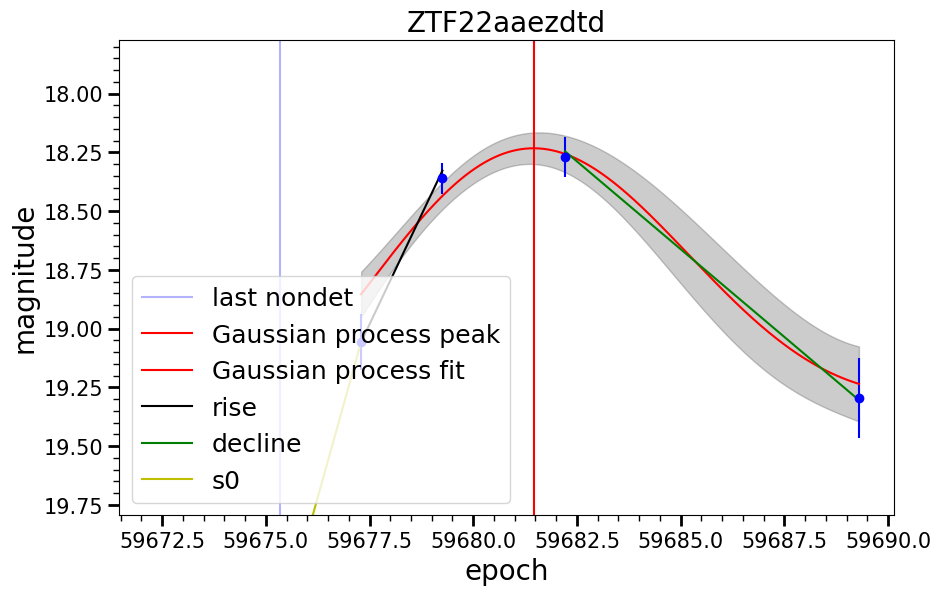

{'oid': 'ZTF22aaezdtd',
 'filt': 'g',
 'meanra': np.float64(190.9063894625),
 'meandec': np.float64(1.3843915375),
 'last_nondet': np.float64(59675.333368100226),
 'first_det': np.float64(59677.29833329981),
 'duration': np.float64(11.996747700031847),
 'ndetection': 4,
 's0': np.float64(0.6327943673017746),
 'rise_time': np.float64(6.122057671251241),
 'peak_mag': np.float64(18.232827022818228),
 'peak_epoch': np.float64(59681.45542577148),
 'rise_time_flag': 1,
 'rise_slope': np.float64(0.37206626580136537),
 'decline_slope': np.float64(0.14941747643239897)}

In [7]:
check_candidates(oid='ZTF22aaezdtd', ifplot=True,filt='g')

[np.float64(58447.49373839982)]
[58450.4889583 58468.5472338 58471.5124537 58472.5334028]
[17.421621 20.099178 20.417    20.248617]


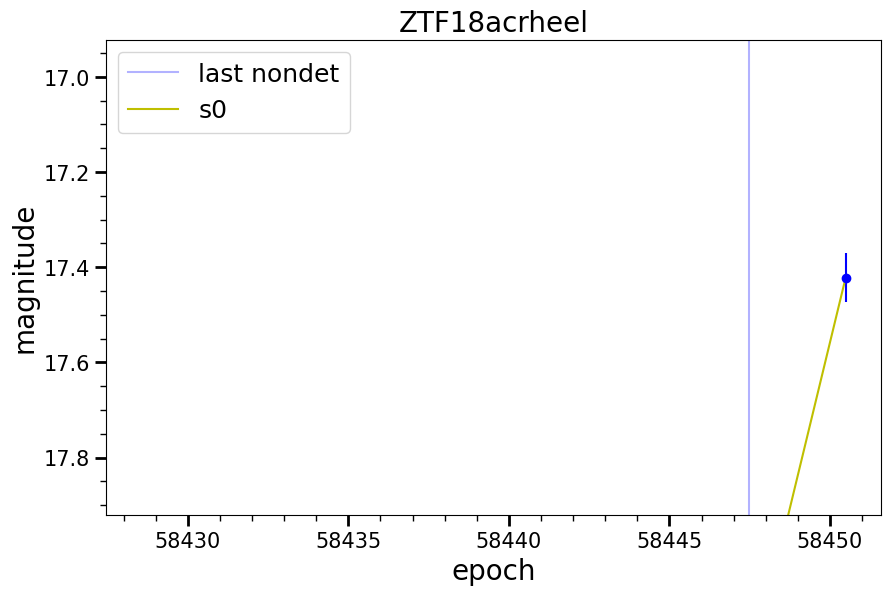

Success: ZTF18acrheel
[np.float64(58494.49447919987)]
[58502.4755324 58505.4484838 58508.5378704 58511.4505208 58514.4723611
 58522.4841088 58526.4460301]
[17.316925 16.887407 16.903444 17.057632 17.48187  18.8368   19.111012]


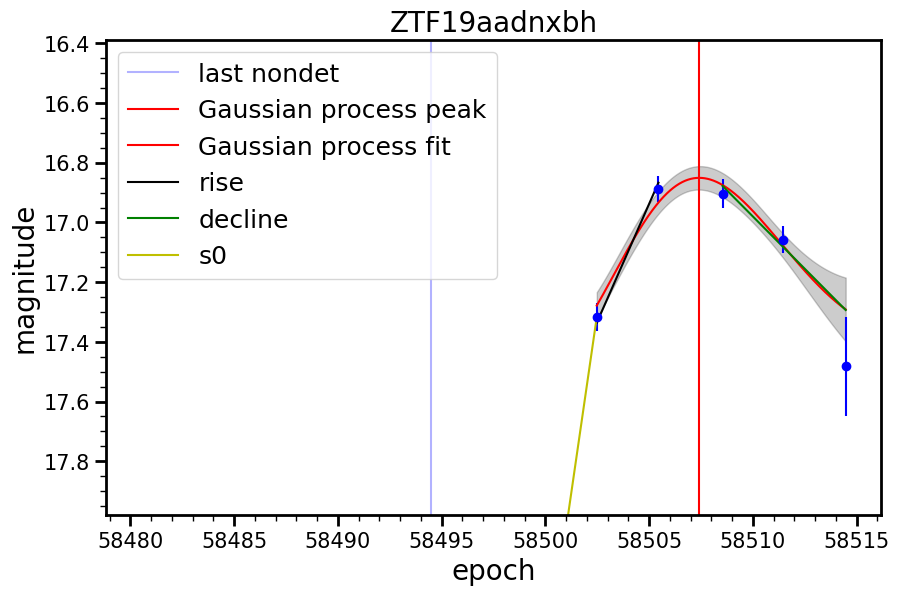

Success: ZTF19aadnxbh
[np.float64(58575.41615739977)]
[58583.3583449 58586.2728819 58589.3951505 58589.3956019 58592.4208681
 58596.250081  58600.2363542 58606.3985995 58606.4179051 58612.2738889]
[17.800669 17.386992 17.4519   17.649029 17.9095   18.26072  18.649118
 19.491661 19.490204 19.970804]


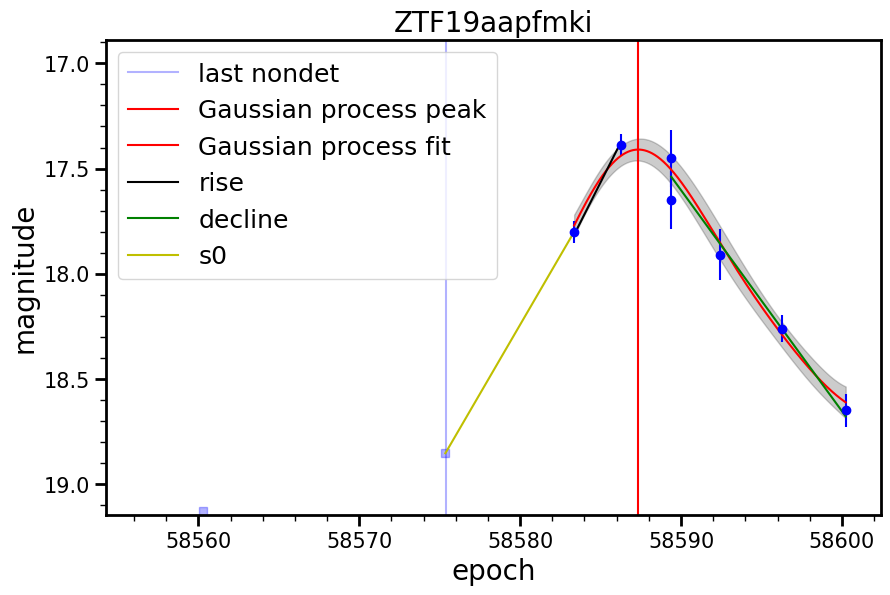

Success: ZTF19aapfmki
[np.float64(58653.44478010014)]
[58660.4572106 58663.4613657 58669.4633681 58672.4291667 58673.4857755
 58675.4501852 58678.4507292 58681.4659838 58684.4215856 58688.4426389
 58690.4852546 58691.4553588 58694.4189352]
[18.19223  17.93823  18.281258 18.47722  18.536373 18.682383 18.94613
 19.122501 19.301697 19.7443   19.88259  19.951197 20.169394]


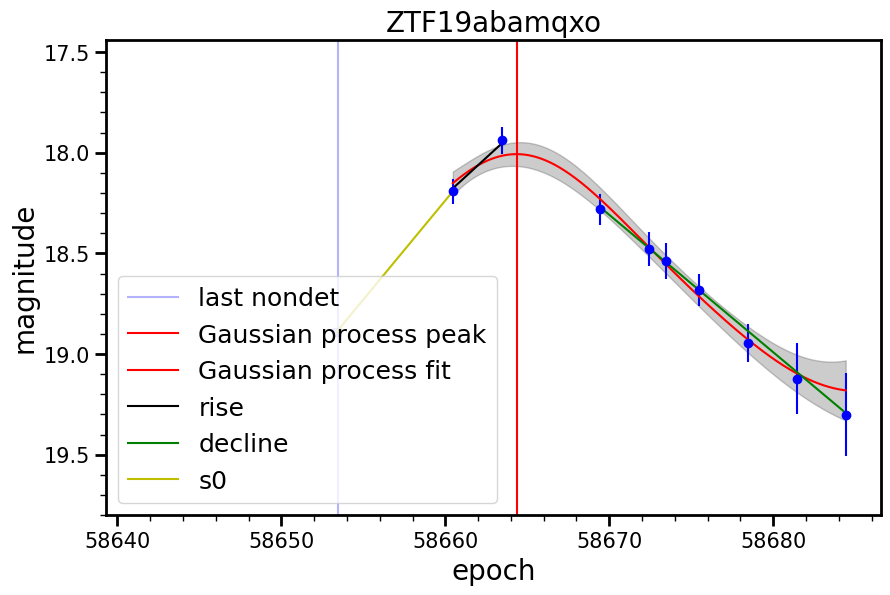

Success: ZTF19abamqxo
[np.float64(58681.242916699965)]
[58684.2062153 58684.2066782 58692.1968056 58692.1972569]
[20.032787 19.885963 18.139456 18.129625]


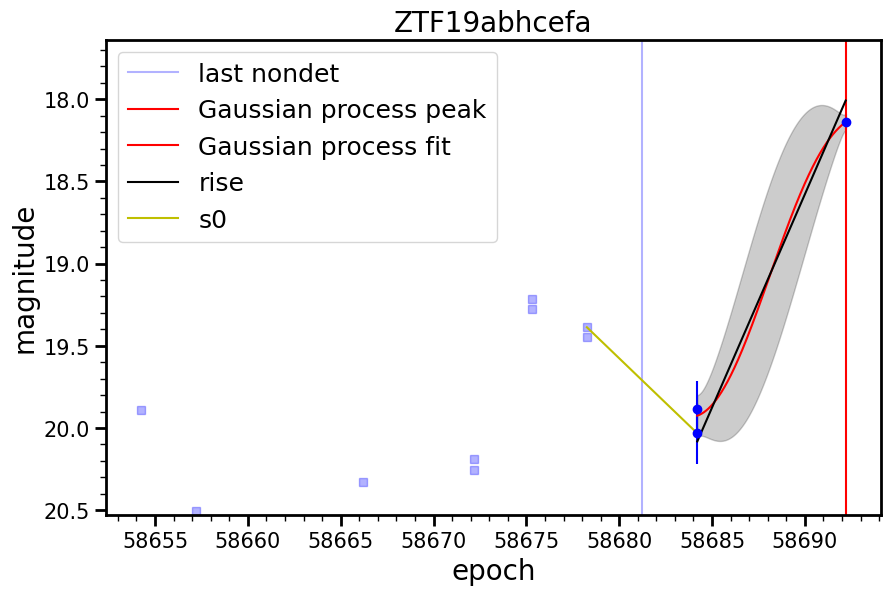

Success: ZTF19abhcefa
[np.float64(58779.50380790001)]
[58785.4625116 58788.5050463 58791.5248611 58796.5467708 58802.5435417]
[20.5231   18.858482 18.429296 18.702272 19.18973 ]


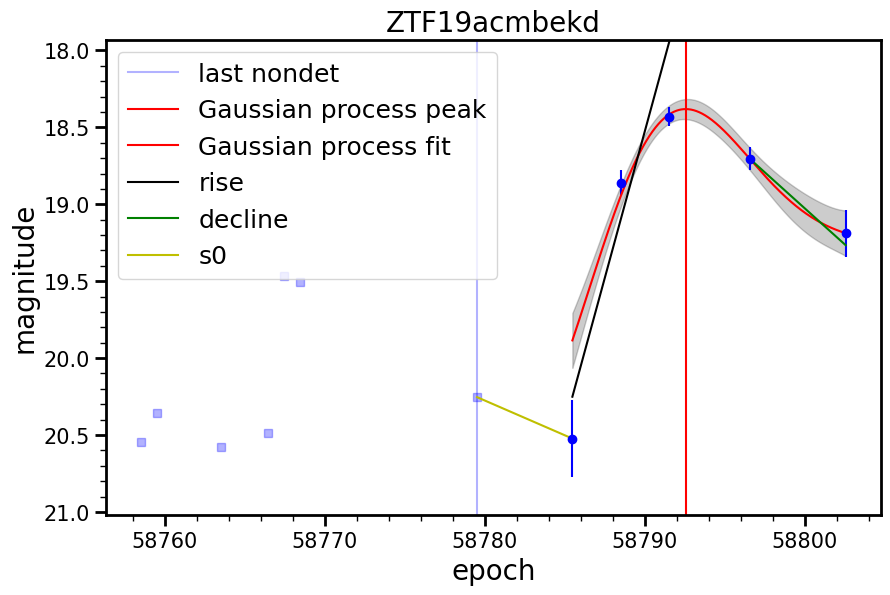

Success: ZTF19acmbekd
[np.float64(58792.514374999795)]
[58792.5473958 58800.5537731 58802.5498032 58804.5100694 58805.5327083]
[19.6917   17.879768 18.062069 18.299156 18.429413]


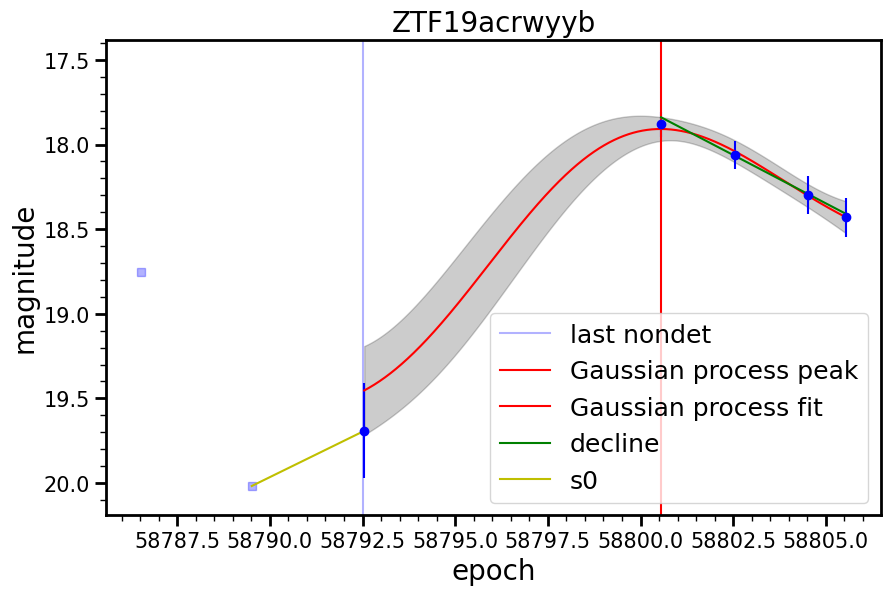

Success: ZTF19acrwyyb
[np.float64(58878.55643519992)]
[58881.5198264 58884.4672222 58887.4633681 58890.5468287 58893.4988194
 58898.5611343 58903.5274537 58906.5251968 58911.5254514 58911.5547338
 58914.4847222]
[18.049957 18.023527 18.121313 17.982988 18.045975 18.024574 18.034302
 18.0582   18.125198 18.070616 18.057535]


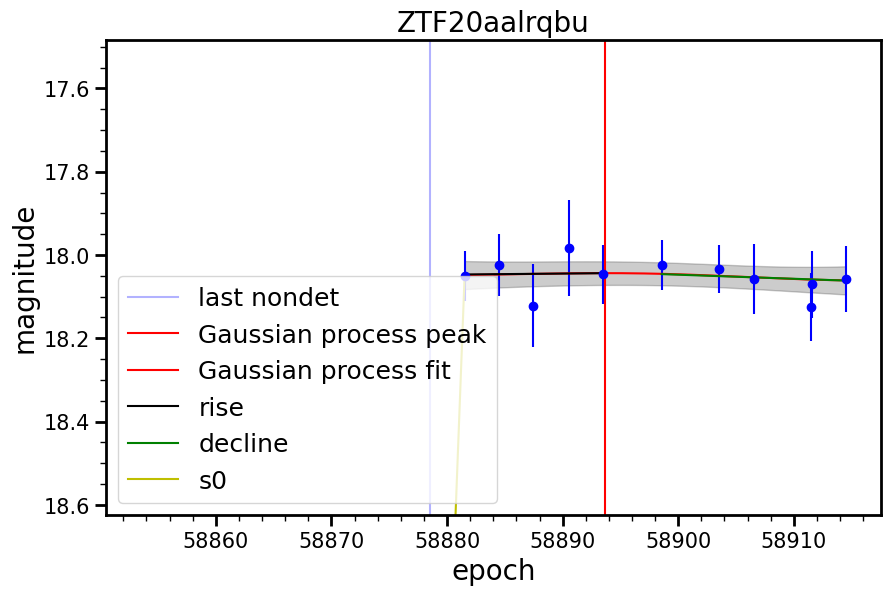

Success: ZTF20aalrqbu
[np.float64(59012.28440969996)]
[59012.309456  59014.3476852 59016.3472338 59017.3238079 59018.3471065
 59019.2858912 59020.3743056 59022.3468056 59023.3279745 59024.2889352
 59025.330706  59026.3675116 59027.2414352 59028.3423611 59029.2612731
 59030.3660648 59031.3263426 59032.3921644 59033.2115509 59034.2165856
 59035.217037  59038.2665741 59041.2223843 59042.3435764 59044.3240162
 59045.2914236 59047.2710764 59050.3717708]
[20.4419   19.82703  19.503544 19.652102 19.518951 19.50621  19.41076
 19.34571  19.321377 19.290504 19.29477  19.225271 19.275585 19.257786
 19.238564 19.202389 19.205288 19.087017 19.171665 19.182745 19.129326
 19.150671 19.200377 19.170462 19.185982 19.248625 19.254547 19.203156]


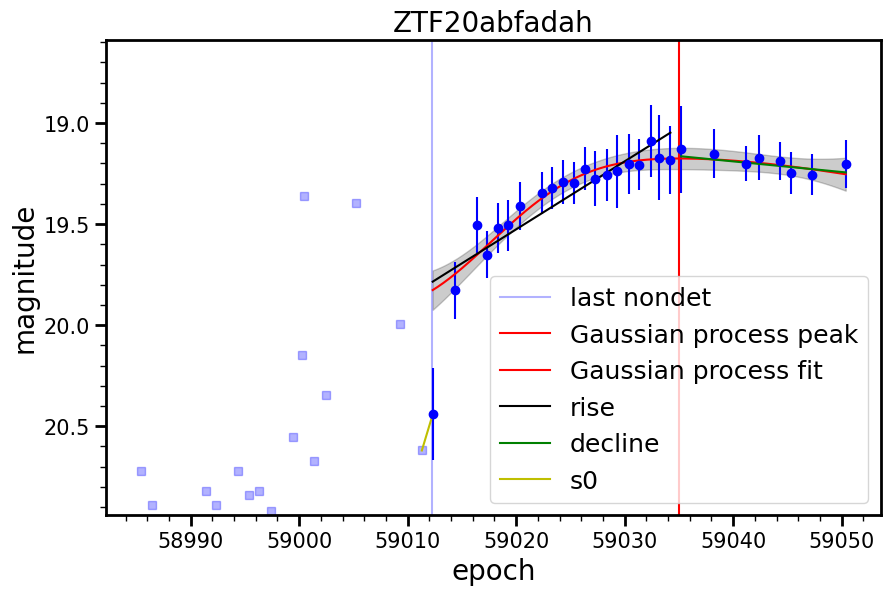

Success: ZTF20abfadah
[np.float64(59099.32572920015)]
[59107.3210532 59110.3104861 59113.1887731 59116.2490856 59116.2914352
 59117.2728356 59119.2205556 59120.2790278 59122.2982407 59123.189838
 59125.2213542 59125.2465162 59126.2276157 59127.2345602 59129.3100694
 59131.2078241]
[18.689175 18.671028 18.760395 18.830149 18.847424 18.920246 19.023066
 19.052944 19.079323 19.2888   19.19699  19.181246 19.334007 19.217361
 19.888668 20.036705]


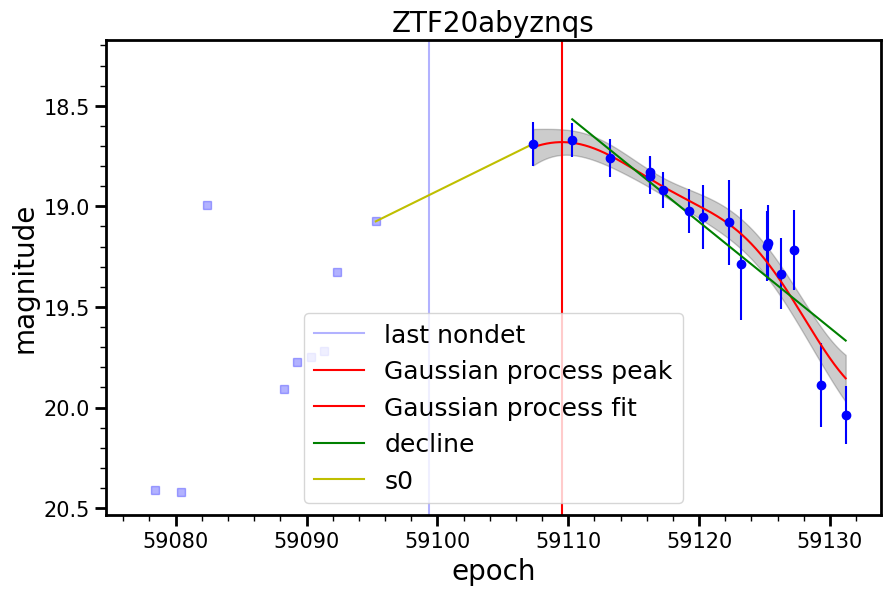

Success: ZTF20abyznqs
[np.float64(59220.11232639989)]
[59220.1381366 59224.1527546 59226.2010069 59228.1600694 59230.1833102
 59232.1211227]
[20.706    18.29145  18.066023 18.142056 18.252579 18.4467  ]


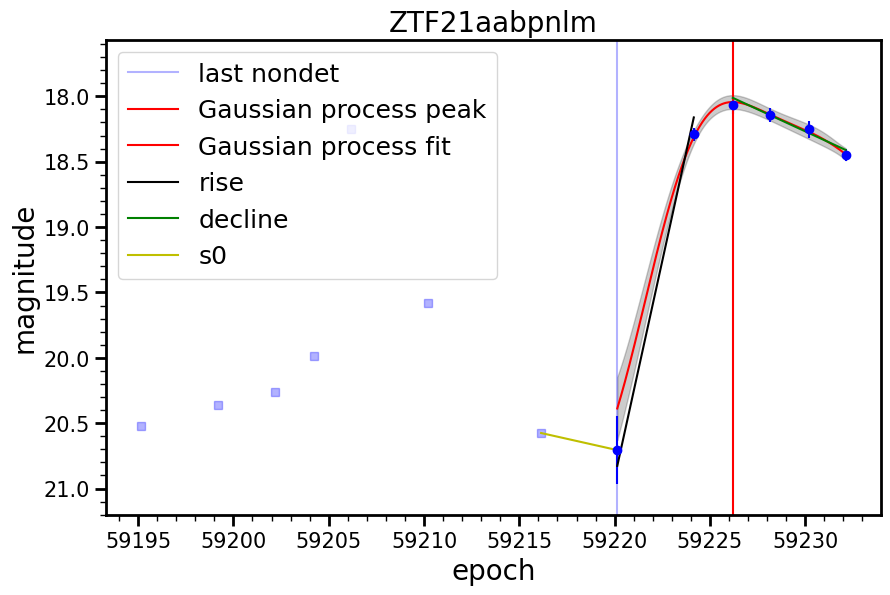

Success: ZTF21aabpnlm
[np.float64(59257.38657409977)]
[59262.5069792 59264.4023264 59266.4943403 59268.4981134 59270.4062153
 59272.3854745 59280.3861574]
[20.244576 19.142159 18.880054 18.80151  18.939861 19.05238  20.023514]


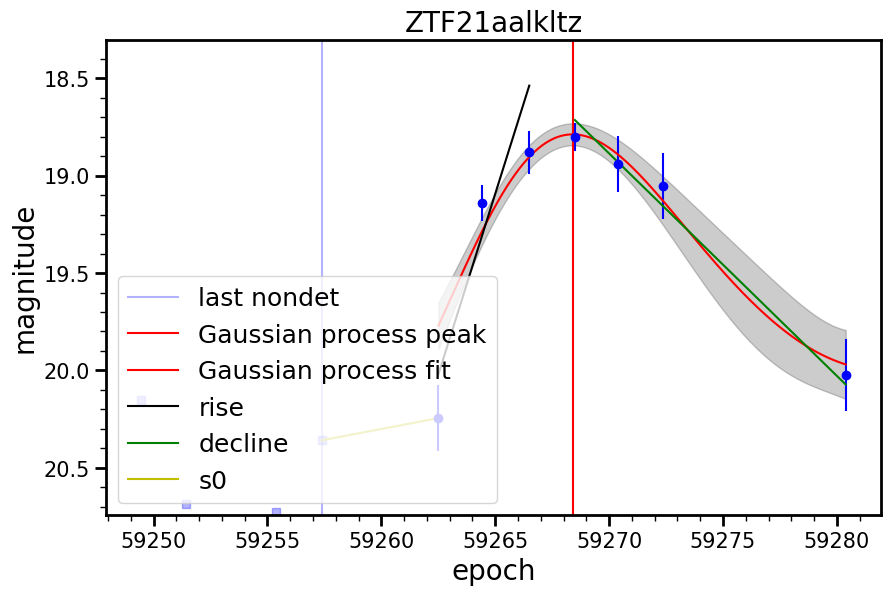

Success: ZTF21aalkltz
[np.float64(59265.251794000156)]
[59267.2328819 59269.2316898 59271.2292361 59273.1715625 59275.1891088
 59278.2122917 59290.2045602 59292.1693981 59294.1692245]
[19.13313  18.133478 17.91845  17.972284 18.219984 18.497541 19.589415
 19.69337  19.86053 ]


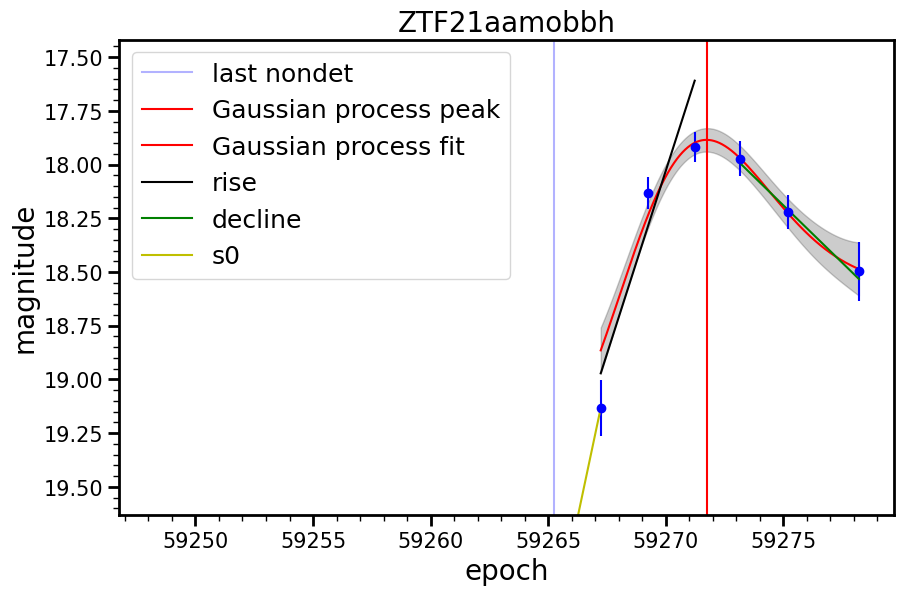

Success: ZTF21aamobbh
[np.float64(59280.19743059995)]
[59290.1993519 59292.1765278 59294.1709028 59296.3112384 59303.2033681
 59306.1593866 59308.1628125 59312.2140625]
[18.103094 17.762604 17.974182 18.142761 19.141869 19.469458 19.637402
 19.838   ]
Error processing ZTF21aapdumx: last non detection is 10 days ago
[np.float64(59312.23228010023)]
[59314.2325579 59316.2115046 59319.2340741 59321.2346181 59323.1754514
 59325.1902546 59335.2128588 59340.1912731]
[19.021875 18.670057 18.905725 19.252092 19.39456  19.641779 20.028238
 20.186325]


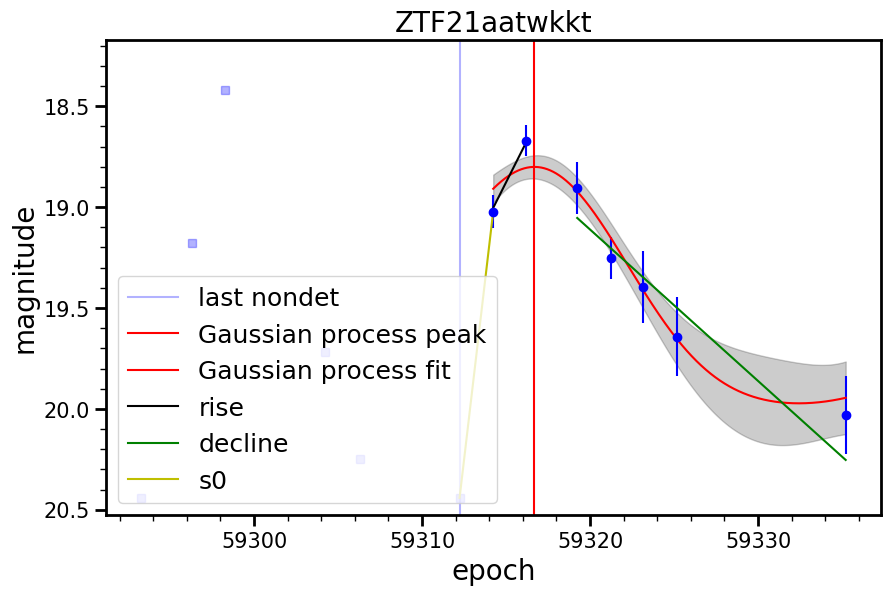

Success: ZTF21aatwkkt
[np.float64(59315.31012730021)]
[59317.289919  59317.289919  59321.3793403 59323.2969097 59325.3591435]
[19.256514 19.2565   18.597807 18.578592 18.770046]


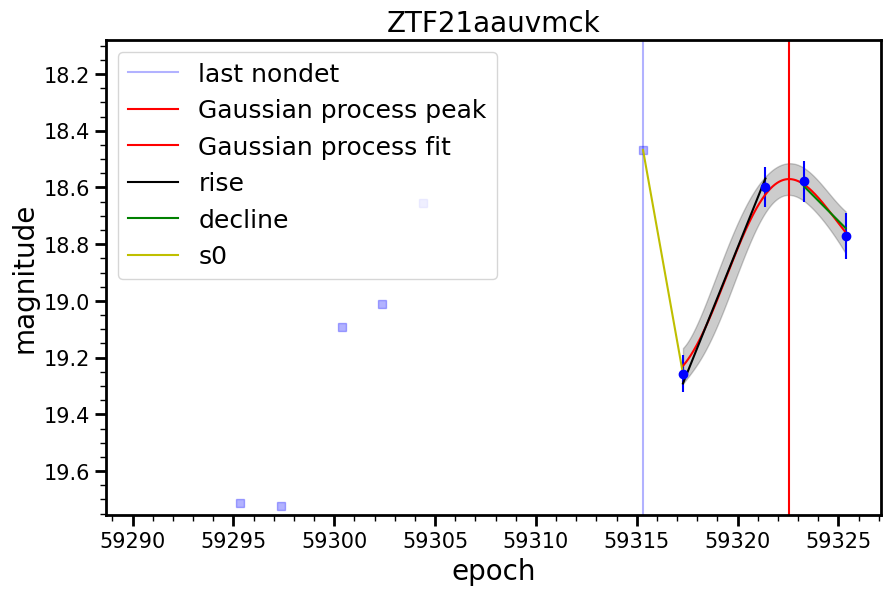

Success: ZTF21aauvmck
[np.float64(59447.2430786998)]
[59450.2693981 59452.3028819 59454.2183565 59458.1815741 59460.3072222
 59462.2844097 59464.2385069 59464.2385069 59466.329537  59468.1831134]
[18.758171 18.612354 18.632074 19.104303 19.34372  19.499523 19.5694
 19.5694   19.68892  19.9965  ]


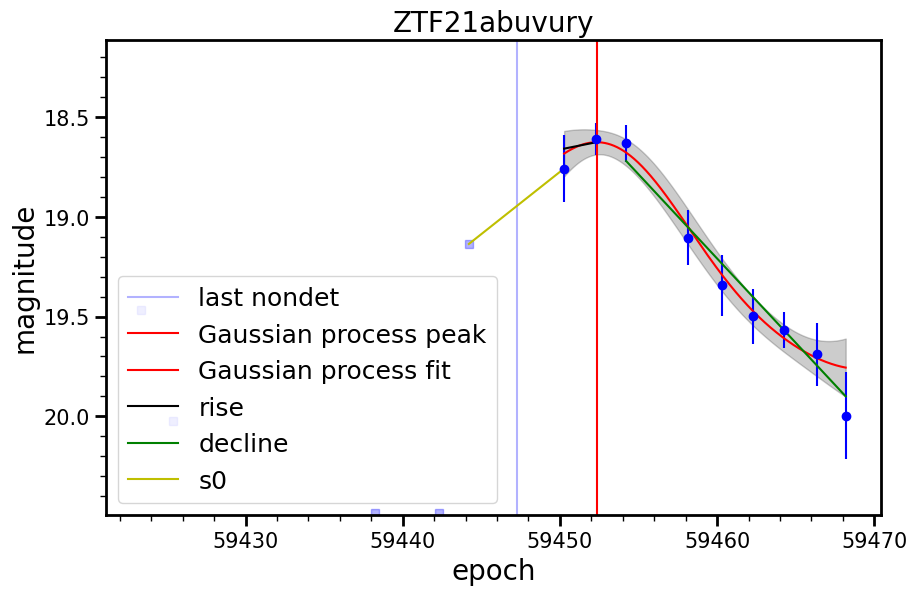

Success: ZTF21abuvury
[np.float64(59489.533425900154)]
[59509.5127894 59512.4920255 59521.5197338 59523.5419329 59525.4854051
 59527.4859606 59532.5198264]
[18.286724 18.5177   19.005722 19.093462 19.183891 19.295324 19.569843]
Error processing ZTF21achujxq: last non detection is 10 days ago
[np.float64(59675.333368100226)]
[59677.2983333 59679.2569444 59682.2122917 59689.295081  59693.338044 ]
[19.056492 18.360853 18.270535 19.295055 19.813396]


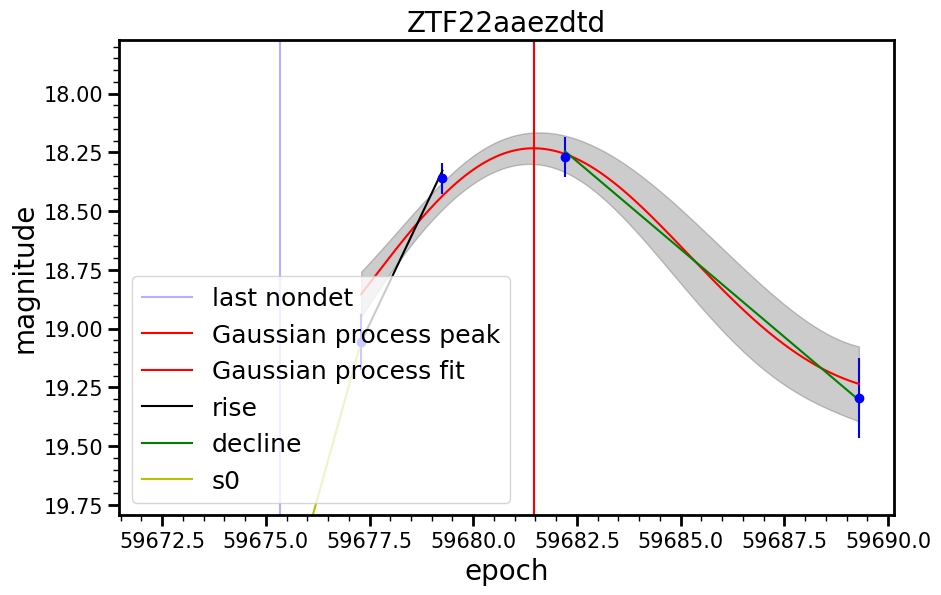

Success: ZTF22aaezdtd
[np.float64(59687.45119210007)]
[59690.4462731 59694.4290509 59696.4283449 59698.4587731 59701.4109144
 59701.4215394 59711.423588  59713.4514931 59717.3223148]
[19.884705 18.43975  18.17796  18.088245 18.163542 18.184639 18.924778
 18.955973 19.8014  ]


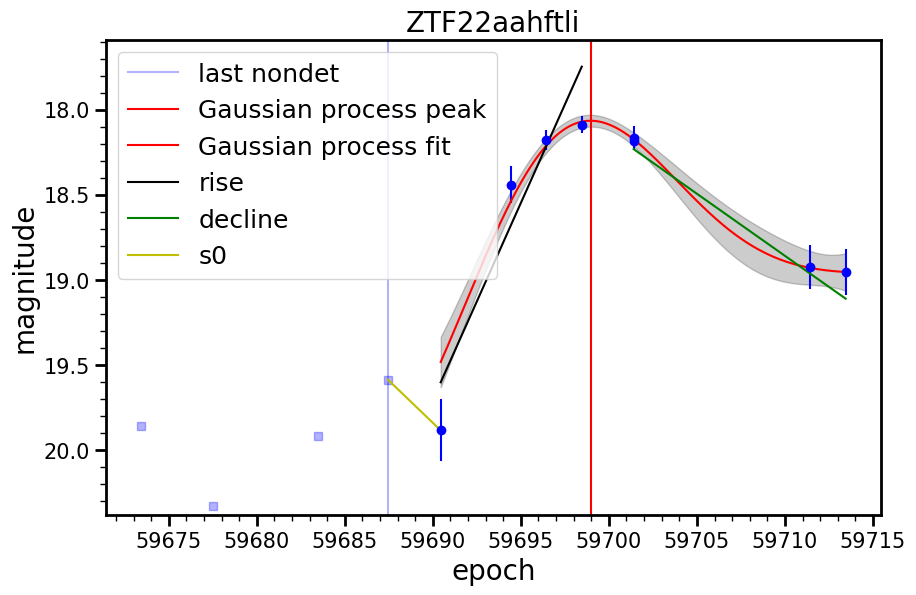

Success: ZTF22aahftli
[np.float64(59768.43854170013)]
[59770.4203588 59785.3348843 59787.3568056]
[20.8205 20.6734 20.8382]


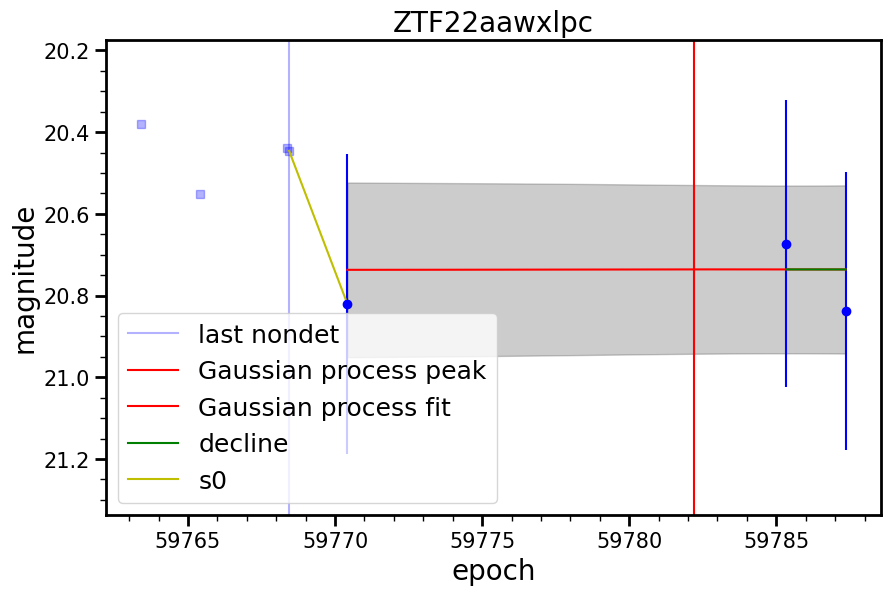

Success: ZTF22aawxlpc
[np.float64(60224.44454859989)]
[60229.4486227 60232.4488542 60234.4718866 60236.4289699 60238.4257176
 60242.4896991 60246.4495718 60250.4677083 60252.4750694 60254.4712153]
[17.961178 17.274134 17.404799 17.635258 17.893206 18.42474  18.575052
 19.075077 19.504194 19.984884]


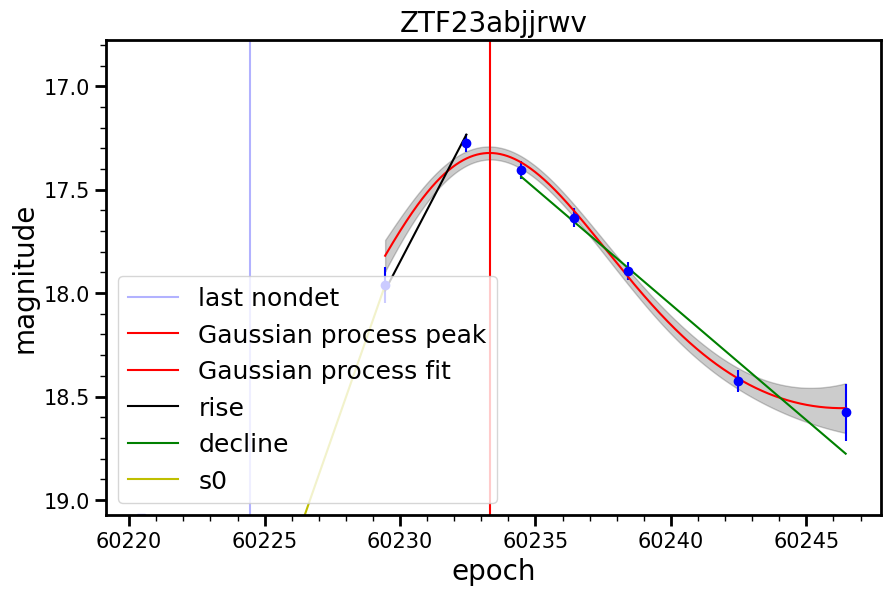

Success: ZTF23abjjrwv
[np.float64(60244.31520830002)]
[60244.3767014 60246.3893171 60249.3763773 60251.3583912 60253.4203009
 60257.3702546 60259.4162269 60261.33125   60262.4231829]
[18.624609 17.910307 17.634657 17.547153 17.661398 17.875656 18.144932
 18.306986 18.38331 ]


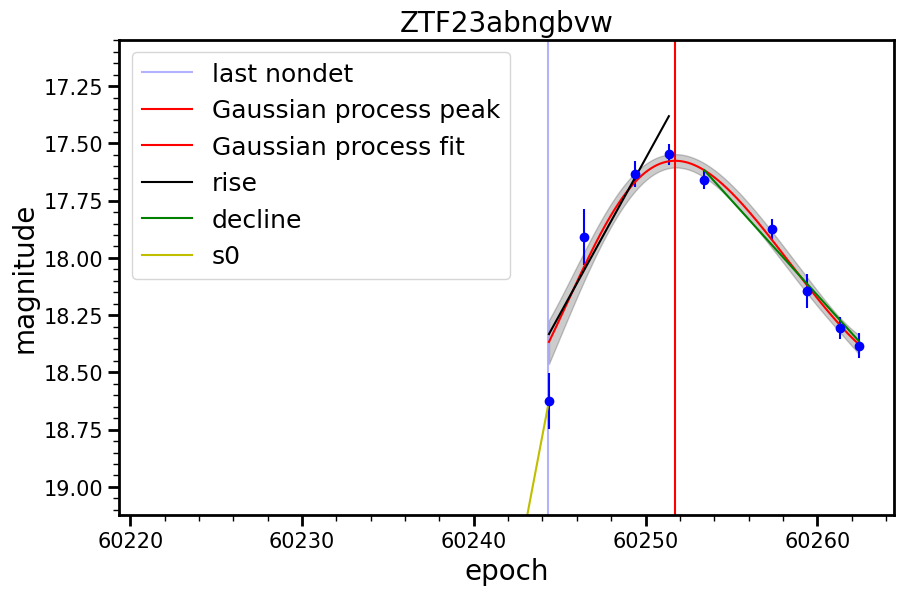

Success: ZTF23abngbvw
[np.float64(60314.154942099936)]
[60323.2152894 60325.2116667 60327.1973727 60336.2227662 60340.1220255]
[18.854115 18.070837 17.93828  19.02141  19.700224]


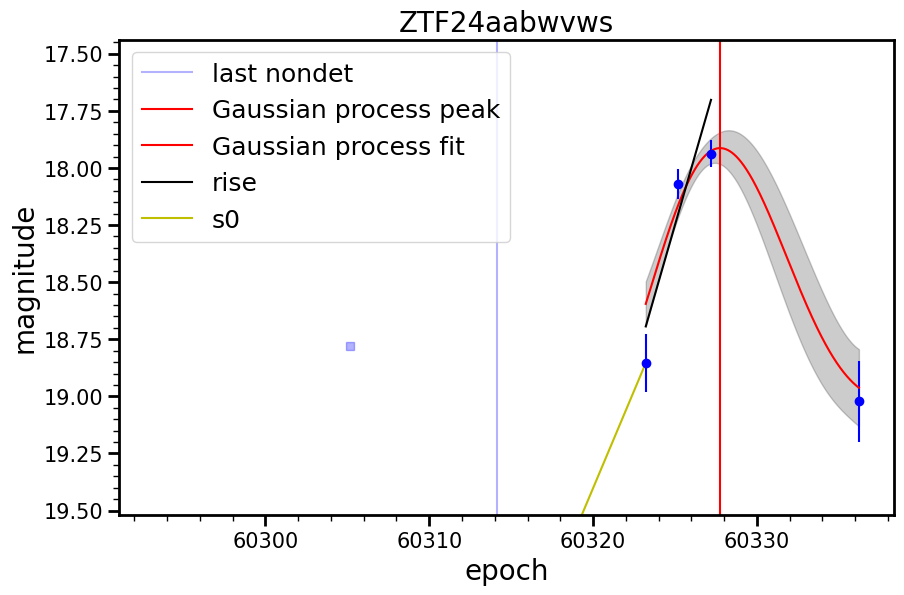

Success: ZTF24aabwvws
[np.float64(60443.24074070016)]
[60443.2903819 60445.2788773 60447.2419329 60449.2626389 60451.3535301
 60455.2155324 60457.2008565 60459.2799306]
[19.236788 18.896633 18.95676  19.373402 19.4321   19.583376 19.937708
 20.024893]


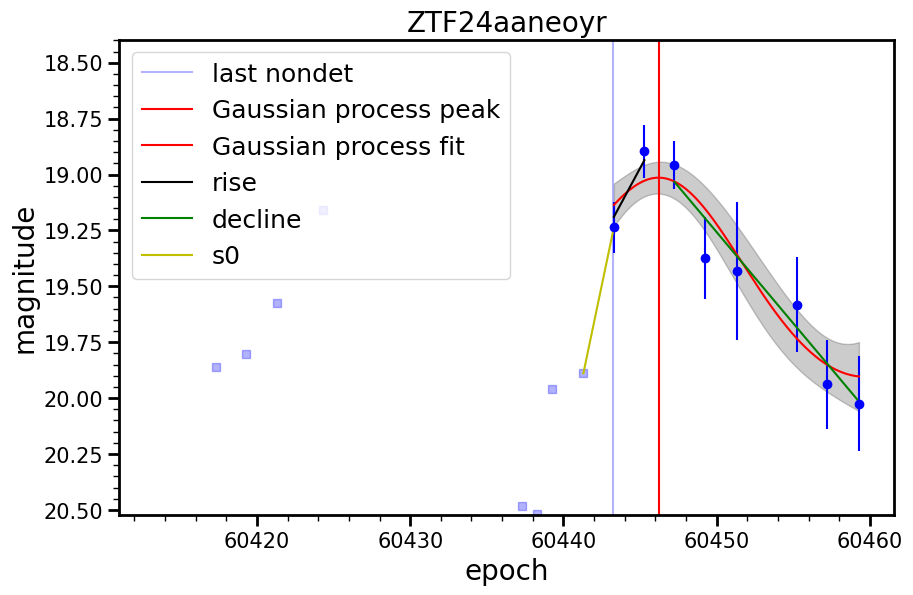

Success: ZTF24aaneoyr
[np.float64(60491.3582175998)]
[60498.1916435 60500.2280208 60502.1941898]
[18.591143 18.719166 18.88951 ]


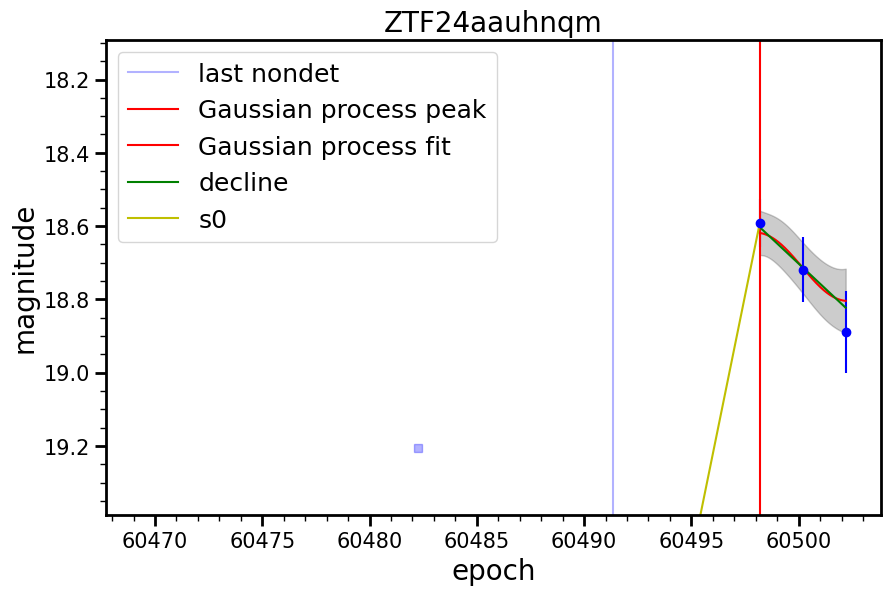

Success: ZTF24aauhnqm
[np.float64(60571.35959490016)]
[60575.4131944 60576.3596412 60577.4327778 60580.4984606 60583.4591088
 60593.3347338]
[17.929098 17.963305 18.015621 18.371199 18.773172 19.939175]


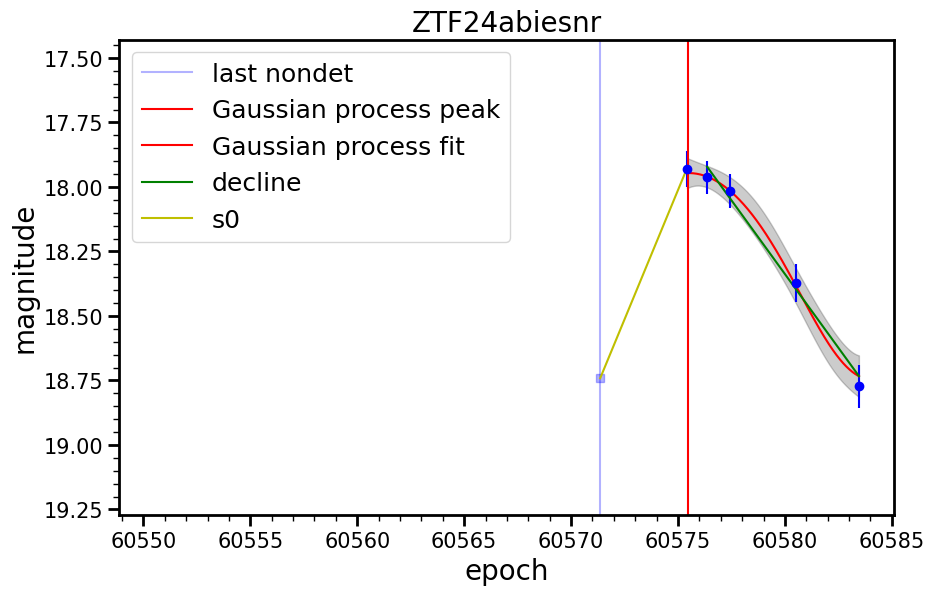

Success: ZTF24abiesnr
[np.float64(60664.40021990007)]
[60666.4364352 60675.4763542 60679.4020833 60680.4222569 60681.3849537
 60684.4406713]
[19.128838 17.644045 18.1054   18.3805   18.408045 18.75822 ]


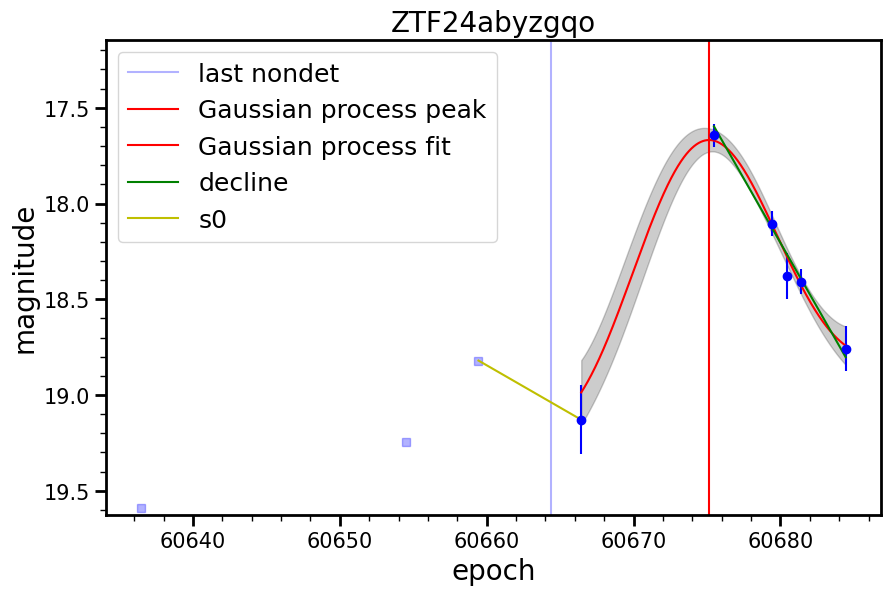

Success: ZTF24abyzgqo


In [ ]:
import re

# why not use PHOT_FILES DATA/ZTF_IBN like in Alex' code so can make direct comparison

# From Alex' Code
def safe_filename(name):
    return re.sub(r'[\\/:"*?<>|]+', '_', name)

flts = ['g','r']
col_flts = {0:'tab:green', 1:'tab:red'}
num_bands = len(flts)

ROOT_DIR = r'C:\Users\jgmad\Research\Ibn'
DATA_DIR =  os.path.join(ROOT_DIR, "data")
PLOT_DIR =  os.path.join(ROOT_DIR, "plots")
PHOT_DIR = os.path.join(DATA_DIR, "ztf_ibn")

phot_files = glob.glob(os.path.join(PHOT_DIR, "*"))

results=[]

for file in phot_files:

    #supernova_name = file.split("/")[-1].split("_")[0]
    filename = os.path.basename(file)
    supernova_name = safe_filename(filename.split("_")[0])

    try:
        result = check_candidates(oid=supernova_name, filt='g', ifplot=True)
        results.append(result)
        print(f"Success: {supernova_name}")
    except Exception as e:
        print(f"Error processing {supernova_name}: {e}")

In [ ]:
df_data = pd.DataFrame(results)
df_data.to_csv("Yize_Data_Ibn.csv", index=False)